# Bio Stages Analysis — RF + Temporal Decoding (Viterbi)

Questo notebook riproduce l'analisi sul dataset bio:

- EDA per classi e per partecipante
- Ranking delle feature via Mutual Information (z-score per partecipante)
- Boxplot e PCA
- Matrice di transizione fra fasi e heatmap
- Validazione cross-partecipante con Random Forest + MI
- Viterbi smoothing con prior di transizione
- Confronto di **normalizzazioni** (Standard, MinMax, Robust) con RF+Viterbi

> **Input atteso:** `/mnt/data/features_dataset.csv` (già caricato).


In [1]:

# Imports
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier

# Matplotlib settings (no specific colors/styles per instruction)
plt.rcParams['figure.figsize'] = (12,6)


## Load dataset

In [2]:

path = "features_dataset.csv"
df = pd.read_csv(path)
print(df.shape)
df.head(3)


(1133, 42)


,bf_mean,bf_std,bf_min,bf_max,bf_range,bf_skew,bf_kurtosis,hr_mean,hr_std,hr_min,...,end,bf_rr,hr_bf_corr_long,hr_slope_long,missing_bf_rr,missing_corr,missing_slope,label,time_center,participant
0,0.132130,0.094891,0.039743,0.333024,0.293281,0.766816,-0.888559,0.622269,0.054852,0.374334,...,10.0,-1.000000,0.000000,0.00000,1,1,1,pranayama,5.0,P2
1,0.163491,0.137262,0.027443,0.379108,0.351664,0.483541,-1.554927,0.617962,0.026614,0.538025,...,20.0,5.168701,-0.175277,-0.00001,0,0,0,pranayama,15.0,P2
2,0.178722,0.118329,0.028639,0.349986,0.321347,0.141199,-1.592671,0.607264,0.036875,0.351207,...,30.0,5.168701,-0.175277,-0.00001,0,0,0,pranayama,25.0,P2


## EDA: distribuzioni globali e per partecipante

,count,percent
label,,
pranayama,336,29.66
chanting,284,25.07
meditation,277,24.45
viparita_swasa,186,16.42
breath_retention,50,4.41


label,breath_retention,chanting,meditation,pranayama,viparita_swasa
participant,,,,,
P2,7,38,27,39,22
P3,6,33,52,46,28
P4,6,55,39,52,25
P5,6,37,21,39,23
P6,9,32,34,40,25
P7,5,28,33,42,24
P8,5,38,50,50,20
P9,6,23,21,28,19


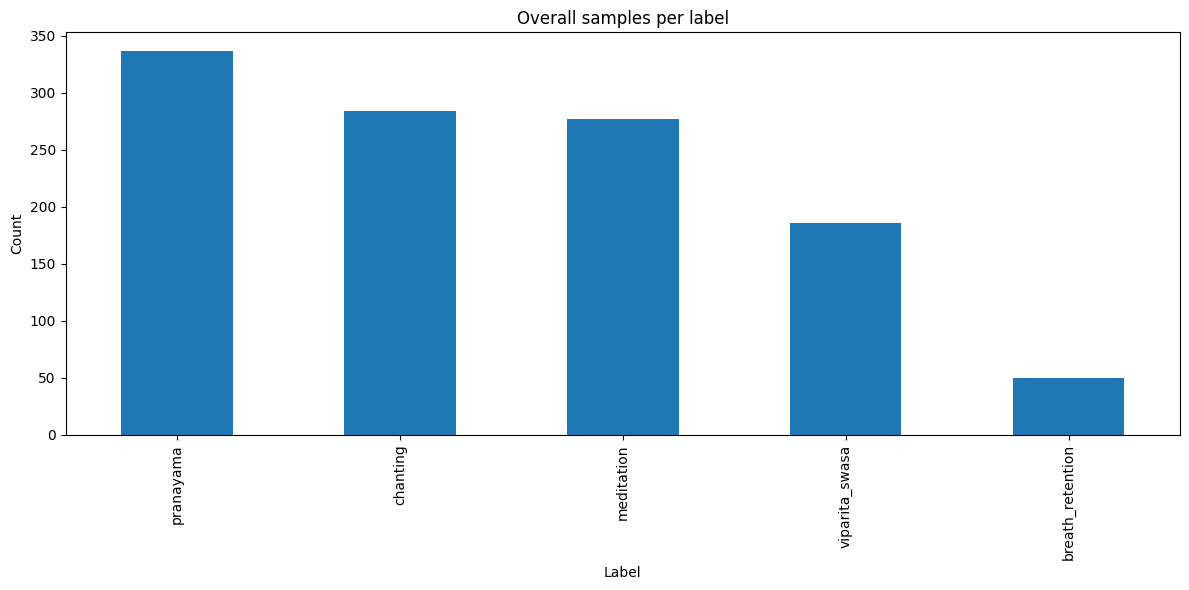

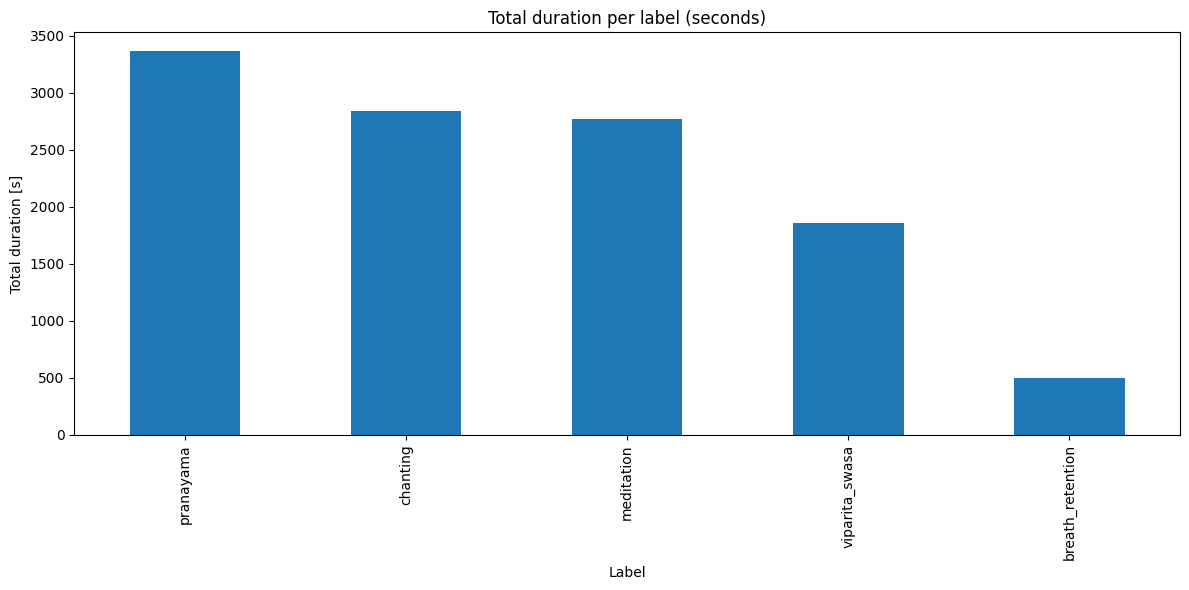

In [3]:

# Overall label distribution
label_counts = df['label'].value_counts().rename_axis("label").to_frame("count")
label_counts["percent"] = (label_counts["count"] / len(df) * 100).round(2)
display(label_counts)

# Counts per participant x label
part_label = (df.groupby(['participant','label'])
                .size()
                .unstack(fill_value=0)
                .sort_index())
display(part_label)

# Plot overall bar
plt.figure()
label_counts['count'].plot(kind='bar')
plt.title("Overall samples per label"); plt.xlabel("Label"); plt.ylabel("Count"); plt.tight_layout(); plt.show()

# Duration per class (if available)
if {'start','end'}.issubset(df.columns):
    df['duration'] = df['end'] - df['start']
    dur = df.groupby('label')['duration'].sum().sort_values(ascending=False)
    plt.figure()
    dur.plot(kind='bar')
    plt.title("Total duration per label (seconds)"); plt.xlabel("Label"); plt.ylabel("Total duration [s]"); plt.tight_layout(); plt.show()


## Normalizzazione per partecipante e Mutual Information

,feature,mi
0,bf_rr,0.480641
1,hr_peak_count,0.455826
2,hr_bpm_from_peaks,0.371379
3,hr_ibi_mean_s,0.343944
4,bf_range,0.312238
5,bf_std,0.288053
6,resp_bp_ratio_fast_slow,0.256703
7,resp_bp_fast,0.256703
8,hr_skew,0.237690
9,resp_spec_entropy,0.217752


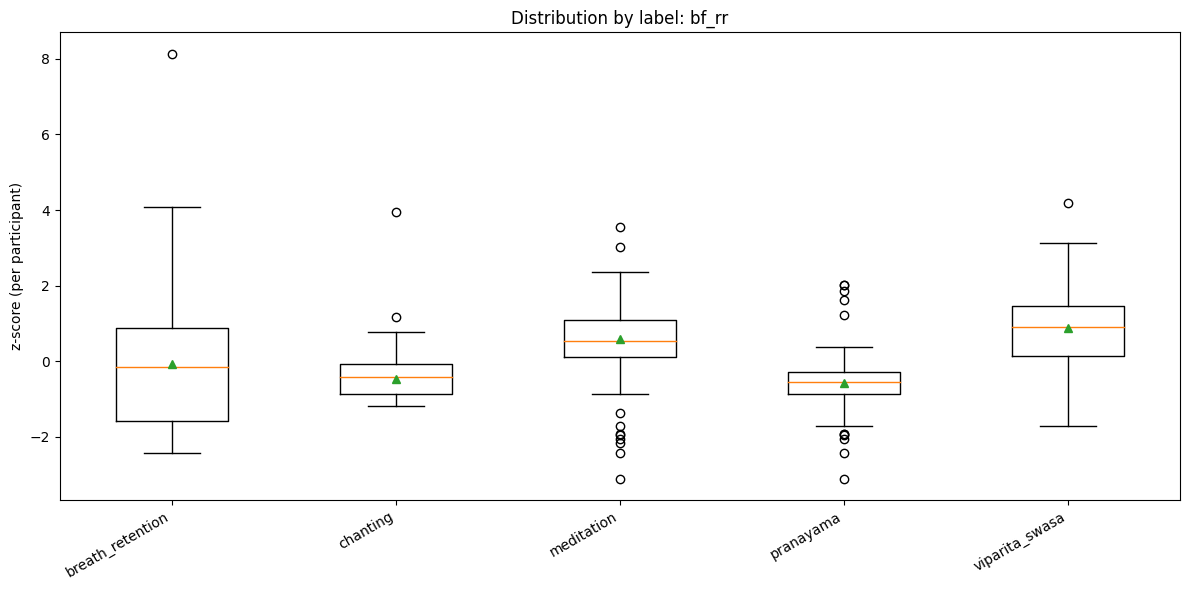

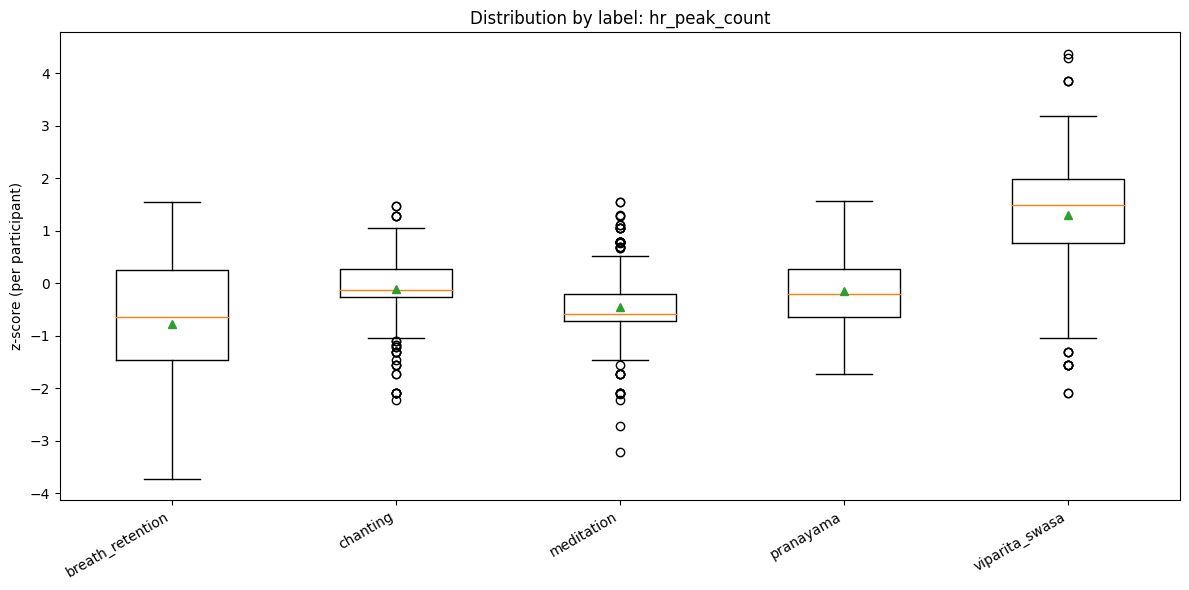

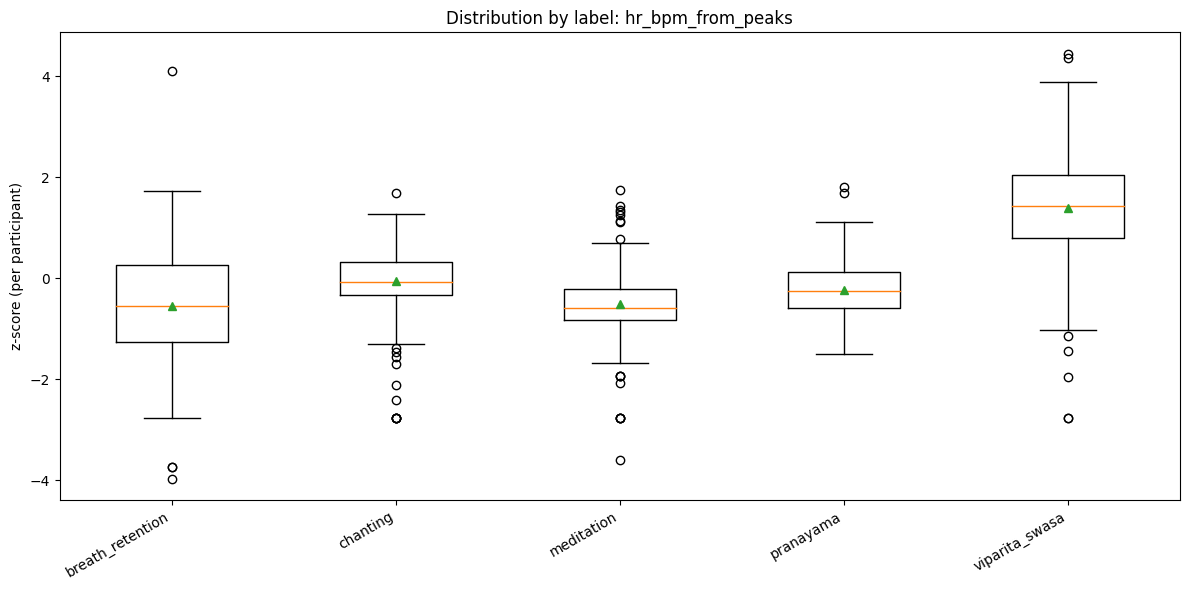

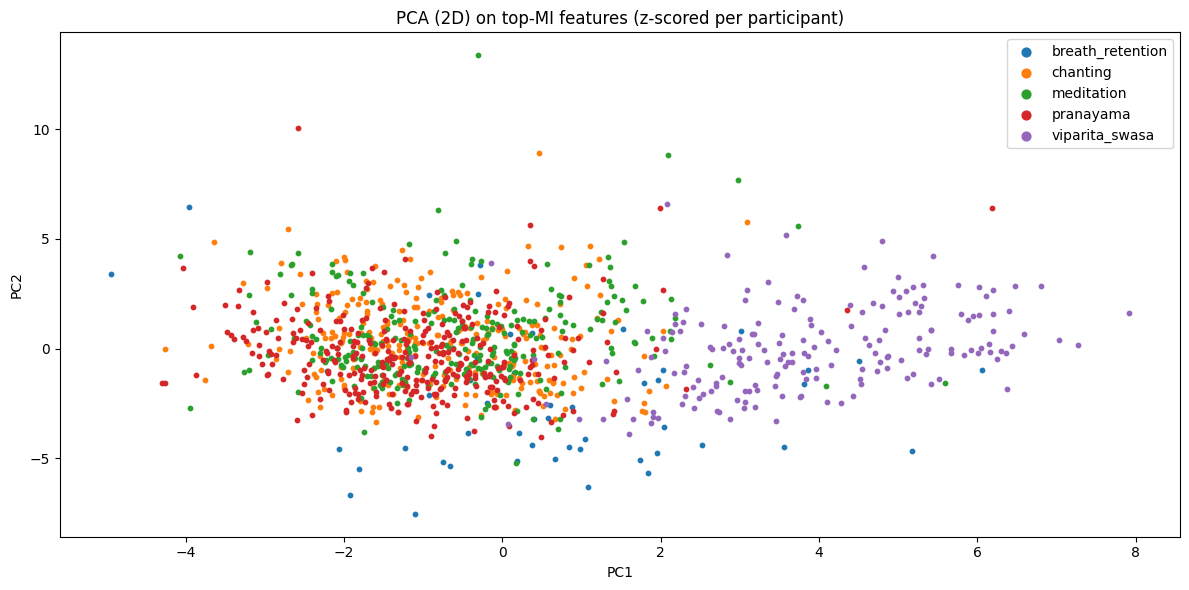

In [4]:

# Identify numeric features
exclude = {"label","participant","time_center","start","end"}
feat_cols = [c for c in df.columns if c not in exclude and pd.api.types.is_numeric_dtype(df[c])]

# Per-participant z-score
df_z = df.copy()
for pid, g in df.groupby("participant"):
    scaler = StandardScaler(with_mean=True, with_std=True)
    df_z.loc[g.index, feat_cols] = scaler.fit_transform(g[feat_cols])

# Encode labels
le = LabelEncoder()
y = le.fit_transform(df_z["label"])
classes = le.classes_.tolist()

# MI ranking
X = df_z[feat_cols].replace([np.inf, -np.inf], np.nan).fillna(0.0)
mi = mutual_info_classif(X, y, discrete_features=False, random_state=42)
mi = np.nan_to_num(mi, nan=0.0)
mi_df = pd.DataFrame({"feature": feat_cols, "mi": mi}).sort_values("mi", ascending=False).reset_index(drop=True)
display(mi_df.head(25))

# Boxplot per le prime 3 feature
top3 = mi_df["feature"].head(3).tolist()
for f in top3:
    plt.figure()
    data = [df_z.loc[df_z['label']==lab, f].values for lab in classes]
    plt.boxplot(data, labels=classes, showmeans=True)
    plt.title(f"Distribution by label: {f}"); plt.ylabel("z-score (per participant)")
    plt.xticks(rotation=30, ha='right'); plt.tight_layout(); plt.show()

# PCA su top-k MI
k = min(30, len(feat_cols))
keep = mi_df.head(k)["feature"].tolist()
pca = PCA(n_components=2, random_state=42)
Z = pca.fit_transform(X[keep])

plt.figure()
for lab in classes:
    sel = (df_z["label"]==lab).values
    plt.scatter(Z[sel,0], Z[sel,1], label=lab, s=10)
plt.title("PCA (2D) on top-MI features (z-scored per participant)")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.legend(markerscale=2); plt.tight_layout(); plt.show()


## Matrice di transizione tra fasi (per participant, in timeline)

,breath_retention,chanting,meditation,pranayama,viparita_swasa
breath_retention,0.782,0.018,0.164,0.018,0.018
chanting,0.003,0.958,0.003,0.003,0.031
meditation,0.004,0.004,0.985,0.004,0.004
pranayama,0.003,0.026,0.003,0.965,0.003
viparita_swasa,0.047,0.005,0.005,0.005,0.937


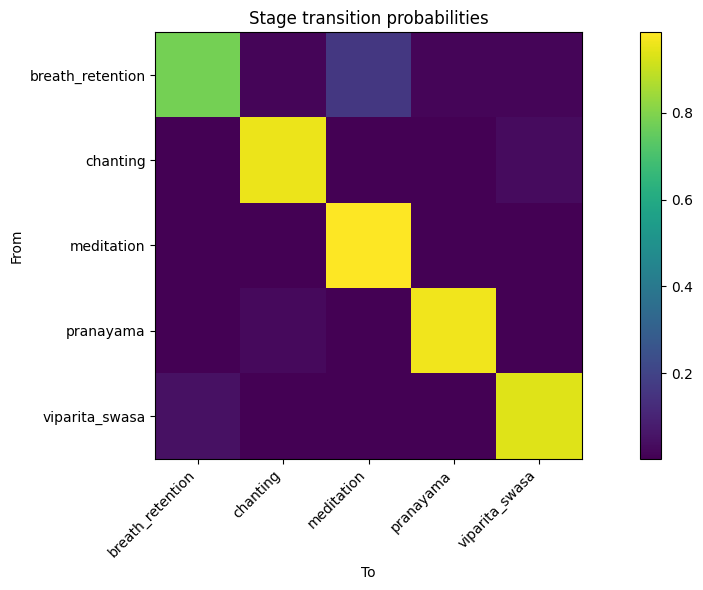

In [5]:

labels = classes
label_to_idx = {lab:i for i,lab in enumerate(labels)}
n = len(labels)
T = np.zeros((n,n), dtype=int)

for pid, g in df.sort_values(['participant','time_center']).groupby('participant'):
    seq = g['label'].values
    for a, b in zip(seq[:-1], seq[1:]):
        T[label_to_idx[a], label_to_idx[b]] += 1

# Probabilità con smoothing di Laplace
T_counts = T + 1
T_prob = T_counts / T_counts.sum(axis=1, keepdims=True)
display(pd.DataFrame(T_prob.round(3), index=labels, columns=labels))

plt.figure()
plt.imshow(T_prob, aspect='equal')
plt.title("Stage transition probabilities")
plt.xlabel("To"); plt.ylabel("From")
plt.xticks(ticks=np.arange(n), labels=labels, rotation=45, ha='right')
plt.yticks(ticks=np.arange(n), labels=labels)
plt.colorbar(); plt.tight_layout(); plt.show()

logT = np.log(T_prob + 1e-9)


## Funzioni utili (Viterbi + CV con RF)

In [6]:

def viterbi_decode(log_emissions, log_trans, log_start=None):
    Tlen, C = log_emissions.shape
    dp = np.full((Tlen, C), -1e18)
    ptr = np.zeros((Tlen, C), dtype=int)
    if log_start is None:
        log_start = np.zeros(C)
    dp[0] = log_start + log_emissions[0]
    for t in range(1, Tlen):
        for j in range(C):
            scores = dp[t-1] + log_trans[:, j]
            ptr[t, j] = int(np.argmax(scores))
            dp[t, j] = scores[ptr[t, j]] + log_emissions[t, j]
    path = np.zeros(Tlen, dtype=int)
    path[-1] = int(np.argmax(dp[-1]))
    for t in range(Tlen-2, -1, -1):
        path[t] = ptr[t+1, path[t+1]]
    return path

def crossval_rf_viterbi(df_norm, feat_cols, n_splits=5, k_mi=30, n_estimators=500):
    X_all = df_norm[feat_cols].replace([np.inf,-np.inf], np.nan).fillna(0.0).values
    y_all = LabelEncoder().fit_transform(df_norm['label'].values)
    groups_all = df_norm['participant'].values
    classes = sorted(df_norm['label'].unique().tolist(), key=lambda x: list(df_norm['label'].unique()).index(x))  # keep original order

    sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=42)
    y_true_all, y_pred_all = [], []

    for fold, (tr, te) in enumerate(sgkf.split(X_all, y_all, groups=groups_all), start=1):
        X_tr, X_te = X_all[tr], X_all[te]
        y_tr, y_te = y_all[tr], y_all[te]

        mi_fold = mutual_info_classif(X_tr, y_tr, discrete_features=False, random_state=42)
        order = np.argsort(mi_fold)[::-1]
        idx_keep = order[:min(k_mi, X_tr.shape[1])]

        X_tr_k, X_te_k = X_tr[:, idx_keep], X_te[:, idx_keep]

        rf = RandomForestClassifier(
            n_estimators=n_estimators, max_depth=None, max_features="sqrt",
            class_weight="balanced", n_jobs=-1, random_state=fold*23 + 9
        )
        rf.fit(X_tr_k, y_tr)
        prob = rf.predict_proba(X_te_k)

        te_idx = np.arange(len(te))
        df_te = df_norm.iloc[te].copy()
        df_te['_idx'] = te_idx
        df_te = df_te.sort_values(['participant','time_center'])

        preds = np.zeros(len(te_idx), dtype=int)
        for pid, g in df_te.groupby('participant'):
            idxs = g['_idx'].values
            log_em = np.log(prob[idxs] + 1e-9)
            path = viterbi_decode(log_em, logT)
            preds[idxs] = path

        y_true_all.append(y_te)
        y_pred_all.append(preds)

    y_true_all = np.concatenate(y_true_all)
    y_pred_all = np.concatenate(y_pred_all)
    return y_true_all, y_pred_all


## Cross-validation per partecipante — RF + MI + Viterbi

Accuracy: 0.744   |   F1-macro: 0.749


,precision,recall,f1-score,support
pranayama,0.929,0.520,0.667,50.000
chanting,0.610,0.662,0.635,284.000
viparita_swasa,0.866,0.913,0.889,277.000
breath_retention,0.629,0.589,0.608,336.000
meditation,0.937,0.957,0.947,186.000
accuracy,0.744,0.744,0.744,0.744
macro avg,0.794,0.728,0.749,1133.000
weighted avg,0.746,0.744,0.742,1133.000


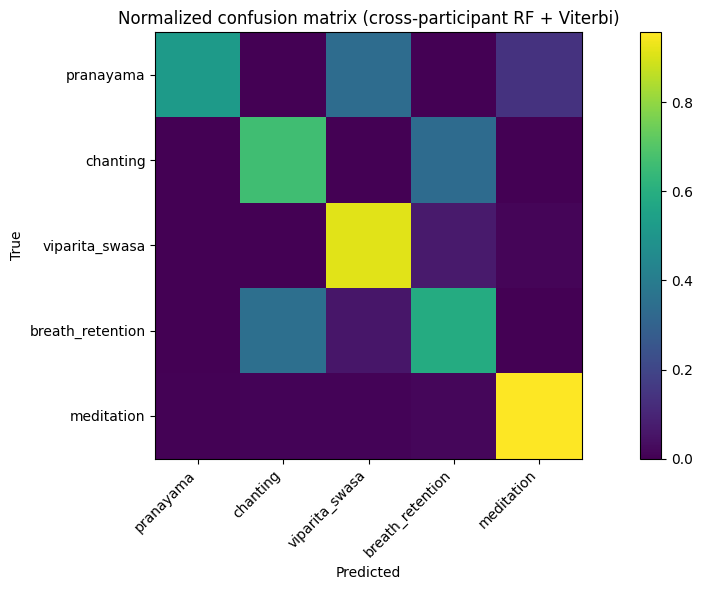

In [7]:

# StandardScaler per partecipante
df_std = df.copy()
for pid, g in df.groupby("participant"):
    scaler = StandardScaler()
    df_std.loc[g.index, feat_cols] = scaler.fit_transform(g[feat_cols])

y_true, y_pred = crossval_rf_viterbi(df_std, feat_cols, n_splits=5, k_mi=30, n_estimators=500)

# Metriche
classes = sorted(df['label'].unique().tolist(), key=list(df['label'].unique()).index)
acc = accuracy_score(y_true, y_pred)
f1m = f1_score(y_true, y_pred, average='macro')
print(f"Accuracy: {acc:.3f}   |   F1-macro: {f1m:.3f}")

rep = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
display(pd.DataFrame(rep).T.round(3))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(len(classes)))
cm_norm = (cm / cm.sum(axis=1, keepdims=True).clip(min=1))

plt.figure()
plt.imshow(cm_norm, aspect='equal')
plt.title("Normalized confusion matrix (cross-participant RF + Viterbi)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks(ticks=np.arange(len(classes)), labels=classes, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(classes)), labels=classes)
plt.colorbar(); plt.tight_layout(); plt.show()


## Confronto normalizzazioni (Standard vs MinMax vs Robust)

In [8]:

def normalize_per_participant(df, feat_cols, scaler):
    out = df.copy()
    for pid, g in df.groupby("participant"):
        out.loc[g.index, feat_cols] = scaler().fit_transform(g[feat_cols])
    return out

def eval_norm(df, feat_cols, scaler, name):
    df_n = normalize_per_participant(df, feat_cols, scaler)
    y_true, y_pred = crossval_rf_viterbi(df_n, feat_cols, n_splits=3, k_mi=20, n_estimators=200)
    classes = sorted(df['label'].unique().tolist(), key=list(df['label'].unique()).index)
    rep = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
    return {
        "acc": accuracy_score(y_true, y_pred),
        "f1_macro": f1_score(y_true, y_pred, average='macro'),
        "f1_retention": rep["breath_retention"]["f1-score"]
    }

results = {}
results["StandardScaler"] = eval_norm(df, feat_cols, StandardScaler, "StandardScaler")
results["MinMaxScaler"]   = eval_norm(df, feat_cols, MinMaxScaler, "MinMaxScaler")
results["RobustScaler"]   = eval_norm(df, feat_cols, RobustScaler, "RobustScaler")

display(pd.DataFrame(results).T.round(3))


,acc,f1_macro,f1_retention
StandardScaler,0.802,0.761,0.679
MinMaxScaler,0.468,0.492,0.392
RobustScaler,0.788,0.733,0.724



## 🔧 LOPOCV + salvataggio modello (pipeline coerente)
Queste celle aggiungono:
- **LabelEncoder globale** e **logT** allineata all'ordine delle classi,
- **LOPOCV** con feature selection (MI) solo sul **train** e **RandomForest** coerente,
- **salvataggio** artefatti per-fold e **modello finale** addestrato su tutto il dataset.


In [9]:

# === Setup coerente ===
import os, json
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Reimport per safety
import matplotlib.pyplot as plt

# Random seeds/fixed params
RANDOM_MI = 42
RF_PARAMS = dict(
    n_estimators=500, max_depth=None, max_features='sqrt',
    class_weight='balanced', n_jobs=-1, random_state=123
)

# Default exclude se non presente

DEFAULT_EXCLUDE = {'participant','label','time_center','start','end'}

# Helper: selezione feature numeriche se feat_cols non esiste
if 'feat_cols' not in globals():
    feat_cols = [c for c in df.columns if c not in DEFAULT_EXCLUDE and pd.api.types.is_numeric_dtype(bio[c])]
    feat_cols = [c for c in feat_cols if df[c].nunique(dropna=True) > 1]

# Helper: per-participant scaling se non esiste
if 'per_participant_scale' not in globals():
    def per_participant_scale(df, feat_cols):
        out = df.copy()
        for pid, g in df.groupby('participant'):
            sc = StandardScaler()
            out.loc[g.index, feat_cols] = sc.fit_transform(g[feat_cols])
        return out

# Helper: MI top-k se non esiste
if 'mutual_info_topk' not in globals():
    def mutual_info_topk(X, y, k=30, random_state=RANDOM_MI):
        mi = mutual_info_classif(X, y, discrete_features=False, random_state=random_state)
        mi = np.nan_to_num(mi, nan=0.0)
        order = np.argsort(mi)[::-1]
        keep = order[:min(k, X.shape[1])]
        return keep, mi

# Helper: Viterbi se non esiste
if 'viterbi_decode' not in globals():
    def viterbi_decode(log_emissions, logT, logpi=None):
        Tn, C = log_emissions.shape
        if logpi is None:
            logpi = np.zeros(C) - np.log(C)
        dp = np.zeros((Tn, C)) - np.inf
        bp = np.zeros((Tn, C), dtype=int)
        dp[0] = logpi + log_emissions[0]
        for t in range(1, Tn):
            for j in range(C):
                scores = dp[t-1] + logT[:, j]
                bp[t, j] = np.argmax(scores)
                dp[t, j] = scores[bp[t, j]] + log_emissions[t, j]
        path = np.zeros(Tn, dtype=int)
        path[-1] = np.argmax(dp[-1])
        for t in range(Tn-2, -1, -1):
            path[t] = bp[t+1, path[t+1]]
        return path

# Helper: matrice di transizione coerente con l'ordine classi
def stage_transition_matrix_from_df(df, classes_order, time_col='time_center'):
    idx = {c:i for i,c in enumerate(classes_order)}
    C = len(classes_order)
    T = np.ones((C, C), dtype=float)  # smoothing add-one
    for pid, g in df.sort_values(['participant', time_col]).groupby('participant'):
        seq = g['label'].values
        for a,b in zip(seq[:-1], seq[1:]):
            if a in idx and b in idx:
                T[idx[a], idx[b]] += 1.0
    T = T / T.sum(axis=1, keepdims=True)
    return T

# Controlli base
assert 'df' in globals(), "Manca il DataFrame `bio`."
for col in ['participant','label','time_center']:
    assert col in df.columns, f"Manca colonna: {col}"

print('Feature numeriche:', len(feat_cols))


Feature numeriche: 38


In [10]:

# === Encoder globale + logT ===
le_global = LabelEncoder().fit(df['label'])
classes = le_global.classes_.tolist()
nC = len(classes)
print('Classi (ordine globale):', classes)

T = stage_transition_matrix_from_df(df, classes_order=classes, time_col='time_center')
logT = np.log(T + 1e-12)


Classi (ordine globale): ['breath_retention', 'chanting', 'meditation', 'pranayama', 'viparita_swasa']


In [11]:

# === LOPOCV coerente ===
participants = df['participant'].unique().tolist()

y_true_all, y_pred_all = [], []
fold_summaries = []

MODEL_DIR = Path('models_lopocv_rf')
MODEL_DIR.mkdir(parents=True, exist_ok=True)

for pid in participants:
    te_mask = (df['participant'] == pid).values
    tr_mask = ~te_mask
    train = df.loc[tr_mask].copy()
    test  = df.loc[te_mask].copy()

    # Scaling per-participant
    tr_scaled = per_participant_scale(train, feat_cols)
    te_scaled = per_participant_scale(test,  feat_cols)

    # X/y con encoder globale
    X_tr = tr_scaled[feat_cols].replace([np.inf,-np.inf], np.nan).fillna(0.0).values
    X_te = te_scaled[feat_cols].replace([np.inf,-np.inf], np.nan).fillna(0.0).values
    y_tr = le_global.transform(tr_scaled['label'])
    y_te = le_global.transform(te_scaled['label'])

    # MI SOLO sul train
    k = min(30, X_tr.shape[1])
    keep_idx, _ = mutual_info_topk(X_tr, y_tr, k=k)
    X_tr_k = X_tr[:, keep_idx]
    X_te_k = X_te[:, keep_idx]
    keep_features = [feat_cols[i] for i in keep_idx]

    # RF coerente
    rf = RandomForestClassifier(**RF_PARAMS)
    rf.fit(X_tr_k, y_tr)

    # Riallineo proba all'ordine globale
    proba_te_fit = rf.predict_proba(X_te_k)
    prob = np.zeros((proba_te_fit.shape[0], nC), dtype=float)
    for j_fit, c_int in enumerate(rf.classes_):  # c_int sono interi in spazio encodato
        prob[:, int(c_int)] = proba_te_fit[:, j_fit]

    # Viterbi su test ordinato temporalmente
    df_te_sorted = te_scaled.sort_values('time_center').copy()
    inv = te_scaled.index.get_indexer(df_te_sorted.index)
    log_em = np.log(prob[inv] + 1e-9)
    path = viterbi_decode(log_em, logT)

    y_true = le_global.transform(df_te_sorted['label'].values)

    y_true_all.append(y_true)
    y_pred_all.append(path)

    # Salvataggi fold
    meta = dict(
        participant=str(pid),
        keep_features=keep_features,
        rf_params=RF_PARAMS,
        classes=classes
    )
    with open(MODEL_DIR / f'fold_{pid}_meta.json', 'w') as f:
        json.dump(meta, f, indent=2)

    out_fold = pd.DataFrame({
        'time_center': df_te_sorted['time_center'].values,
        'y_true': y_true,
        'y_pred': path
    })
    out_fold.to_csv(MODEL_DIR / f'fold_{pid}_pred.csv', index=False)

# Metriche aggregate LOPOCV
y_true_all = np.concatenate(y_true_all)
y_pred_all = np.concatenate(y_pred_all)

acc = accuracy_score(y_true_all, y_pred_all)
f1m = f1_score(y_true_all, y_pred_all, average='macro')
print('LOPOCV — Accuracy:', round(acc,3), '| F1-macro:', round(f1m,3))

rep = classification_report(y_true_all, y_pred_all, target_names=classes, output_dict=True)
pd.DataFrame(rep).T.round(3)


LOPOCV — Accuracy: 0.83 | F1-macro: 0.794


,precision,recall,f1-score,support
breath_retention,0.913,0.420,0.575,50.00
chanting,0.726,0.940,0.819,284.00
meditation,0.855,0.917,0.885,277.00
pranayama,0.866,0.652,0.744,336.00
viparita_swasa,0.932,0.962,0.947,186.00
accuracy,0.830,0.830,0.830,0.83
macro avg,0.858,0.778,0.794,1133.00
weighted avg,0.841,0.830,0.823,1133.00


In [12]:

# === Train finale su tutto il dataset + salvataggio modello ===
try:
    import joblib
except Exception as e:
    from sklearn.externals import joblib  # fallback per versioni vecchie

# Per-participant scaling su tutto
bio_full = per_participant_scale(df, feat_cols)
X_full = bio_full[feat_cols].replace([np.inf,-np.inf], np.nan).fillna(0.0).values
y_full = le_global.transform(bio_full['label'].values)

# MI su tutto (solo per il modello finale, NON usata nel LOPOCV)
keep_idx_full, mi_full = mutual_info_topk(X_full, y_full, k=min(30, X_full.shape[1]))
sel_features = [feat_cols[i] for i in keep_idx_full]

rf_final = RandomForestClassifier(**RF_PARAMS)
rf_final.fit(X_full[:, keep_idx_full], y_full)

model_blob = {
    "rf": rf_final,
    "selected_features": sel_features,
    "classes": classes,
    "exclude_cols": list(DEFAULT_EXCLUDE),
    "scaler": "StandardScaler_per_participant",
    "transition_matrix": T,          # stessa indicizzazione di classes
    "rf_params": RF_PARAMS
}
model_blob["feature_selection"] = {
    "method": "mutual_info_classif",
    "k": len(sel_features),
    "random_state": 42,
    "scope": "final_full_dataset",
    "scaling": "per_participant"
}
model_dir = Path("./models")

model_dir.mkdir(parents=True, exist_ok=True)
model_path = model_dir / "bio_rf_model.joblib"
joblib.dump(model_blob, str(model_path))
print("Modello salvato:", str(model_path))


Modello salvato: models\bio_rf_model.joblib
